## Environments
Estos entornos permiten 3 intentos (vidas) para superar las 32 etapas en el juego. Los entornos solo envían fotogramas de juego recompensables a agentes; No se envían escenas de corte, pantallas de carga, etc. desde el emulador de NES a un agente ni puede un agente realizar acciones durante estas instancias. Si un La escena no se puede saltar pirateando la RAM de la NES, el entorno bloqueará el proceso de Python hasta que el emulador esté listo para la siguiente acción.


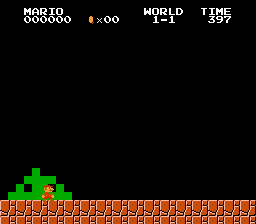


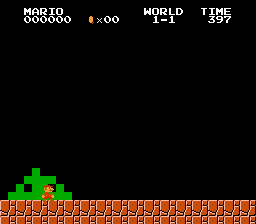

In [ ]:
#librerias necesarias
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install swig
!pip install gym[atari,box2d,accept-rom-license]  #install gym and virtual display
!pip install gym-super-mario-bros

In [ ]:
from __future__ import absolute_import, division, print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tf_agents.environments import tf_py_environment, gym_wrapper, tf_py_environment
from tf_agents.environments.wrappers import ActionRepeat
from tf_agents.networks.q_network import QNetwork
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.utils import common
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy


# To get smooth animations
import matplotlib.animation as animation
matplotlib.rc('animation', html='jshtml')

from IPython.display import HTML

import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT


In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
print(env.get_action_meanings())
state = env.reset()
env.step(env._action_space.sample())
img = env.render(mode="rgb_array")
plt.figure(figsize=(4, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
# Crear el entorno
def create_environment():
    import gym
    from nes_py.wrappers import JoypadSpace
    import gym_super_mario_bros
    from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
    env = gym_super_mario_bros.make('SuperMarioBros-v1')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = gym_wrapper.GymWrapper(env)
    return env

eval_py_env = create_environment()
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)



# Crear una política aleatoria
random_policy = random_tf_policy.RandomTFPolicy(
    time_step_spec=eval_env.time_step_spec(),
    action_spec=eval_env.action_spec()
)

# Definir la función para ejecutar y visualizar la política aleatoria
def run_and_visualize_random(policy, env, max_steps=1000):
    frames = []
    time_step = env.reset()
    policy_state = policy.get_initial_state(env.batch_size)
    step_count = 0
    while not time_step.is_last() and step_count < max_steps:
        action_step = policy.action(time_step, policy_state)
        policy_state = action_step.state
        time_step = env.step(action_step.action)
        # Captura la observación actual
        frame = time_step.observation.numpy()[0]
        # Transforma la observación para visualizar
        frame = frame.astype(np.uint8)
        frames.append(frame)
        step_count += 1
    return frames

# Definir las funciones de animación
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Ejecutar la política aleatoria y visualizar el juego
frames = run_and_visualize_random(random_policy, eval_env, max_steps=1000)
anim = plot_animation(frames)

from IPython.display import HTML
HTML(anim.to_jshtml())


In [ ]:
# Create and wrap the environment
def create_environment():
    # Load the Super Mario Bros environment
    env = gym_super_mario_bros.make('SuperMarioBros-v1')
    # Simplify the action space
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    # Apply preprocessing wrappers
    env = gym.wrappers.GrayScaleObservation(env, keep_dim=True)
    env = gym.wrappers.ResizeObservation(env, 84)
    env = gym.wrappers.FrameStack(env, 4)
    env = gym_wrapper.GymWrapper(env)
    return env

In [ ]:
# Instantiate training and evaluation environments
train_py_env = create_environment()
eval_py_env = create_environment()

In [ ]:
# Convert to TensorFlow Agents environments
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
# Define the Q-network
preprocessing_layer = tf.keras.layers.Lambda(lambda x: tf.cast(x, np.float32) / 255.)
conv_layer_params = [
    (32, (8, 8), 4),
    (64, (4, 4), 2),
    (64, (3, 3), 1),
]
fc_layer_params = [512]

q_net = QNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

# Create the DQN agent
optimizer = tf.compat.v1.train.RMSPropOptimizer(
    learning_rate=2.5e-4,
    decay=0.95,
    momentum=0.0,
    epsilon=0.01,
    centered=True
)
train_step_counter = tf.Variable(0)

agent = DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    gamma=0.99,
    epsilon_greedy=0.1,
    target_update_period=10000
)


In [ ]:
agent.initialize()

# Create the replay buffer
replay_buffer = TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000
)

In [ ]:
# Function to collect experience
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

# episode_rewards = []
# current_episode_reward = 0

# def collect_step(environment, policy, buffer, prev_x=[0]):
#     global current_episode_reward, episode_rewards

#     time_step = environment.current_time_step()
#     action_step = policy.action(time_step)
#     next_time_step = environment.step(action_step.action)

#     # Extraer x_pos del entorno original
#     # info = environment.pyenv.envs[0].get_info()
#     # x_pos = info.get('x_pos', 0)
    
#     # Fallback al obtener x_pos para calcular la recompensa personalizada
#     try:
#         info = environment.pyenv.envs[0].get_info()
#         x_pos = info.get('x_pos', 0)  # Si no está la clave, usa 0
#     except Exception as e:
#         print(f"⚠️ Error al obtener x_pos: {e}")
#         x_pos = 0  # Fallback total
    
#     # Calcular recompensa basada en desplazamiento en x
#     reward = x_pos - prev_x[0]
#     prev_x[0] = x_pos

#     # Acumular recompensa del episodio actual
#     current_episode_reward += reward

#     # Detectar si termina el episodio
#     if next_time_step.is_last():
#         print(f"✅ Episodio terminado. Recompensa acumulada: {current_episode_reward}")
#         episode_rewards.append(current_episode_reward)
#         current_episode_reward = 0

#     # Reemplazar la recompensa
#     next_time_step = next_time_step._replace(reward=tf.convert_to_tensor([reward], dtype=tf.float32))

#     traj = trajectory.from_transition(time_step, action_step, next_time_step)
#     buffer.add_batch(traj)
    
# Collect initial data with a random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
initial_collect_steps = 1000
for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy, replay_buffer)

# Prepare the dataset
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=32,
    num_steps=2
).prefetch(3)
iterator = iter(dataset)



In [ ]:
# Training the agent
num_iterations = 100000  # Adjust this value based on Kaggle's computational limits
collect_steps_per_iteration = 1
log_interval = 300
# Lista para almacenar las pérdidas
losses = []

for iteration in range(num_iterations):
    # Collect experience
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
    # Sample a batch of data and train the agent
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss
    if iteration % log_interval == 0:
        print(f'Iteration: {iteration}, Loss: {train_loss}')
        print(f'Iteración {iteration + 1}/{num_iterations}')
        print(f'Pérdida de entrenamiento (loss): {train_loss.numpy():.4f}')
        print(f'Pasos de entrenamiento acumulados: {train_step_counter.numpy()}')


# try:
#     for iteration in range(num_iterations):
#         print(f"\n🔁 Iteración {iteration + 1}/{num_iterations}")

#         for _ in range(collect_steps_per_iteration):
#             collect_step(train_env, agent.collect_policy, replay_buffer)

#         experience, _ = next(iterator)
#         train_loss = agent.train(experience).loss

#         losses.append(train_loss.numpy())  # Guardar pérdida


#         print(f"   Pérdida: {train_loss.numpy():.4f}")
#         print(f"   Paso de entrenamiento: {train_step_counter.numpy()}")

# except Exception as e:
#     print(f"🚨 Error durante el entrenamiento en la iteración {iteration}: {e}")


In [ ]:
# import matplotlib.pyplot as plt

# # Graficar la pérdida
# plt.figure(figsize=(10, 6))
# plt.plot(losses, label='Pérdida por iteración')
# plt.xlabel('Iteración')
# plt.ylabel('Pérdida')
# plt.title('Evolución de la Pérdida durante el Entrenamiento')
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(episode_rewards, label='Recompensa total por episodio')
# plt.xlabel('Episodio')
# plt.ylabel('Recompensa acumulada (x_pos)')
# plt.title('Progreso del agente de Mario')
# plt.grid(True)
# plt.legend()
# plt.show()

In [ ]:
# Evaluate the agent's performance
log_interval = 5
num_eval_episodes = 2
for episode in range(num_eval_episodes):
    time_step = eval_env.reset()
    episode_reward = 0
    i = 0
    while not time_step.is_last():
        action_step = agent.policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        episode_reward += time_step.reward
        i+=1
       
        if i % log_interval == 0:
            print(f'Episode {episode + 1}: Ite.: {i} :episode_reward : {episode_reward.numpy()[0]}')
    print(f'Episode {episode + 1}: Reward = {episode_reward.numpy()[0]}')

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.environments import wrappers as tf_env_wrappers
from tf_agents.environments import gym_wrapper
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym_super_mario_bros

# Crear el entorno
def create_environment():
    env = gym_super_mario_bros.make('SuperMarioBros-v1')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = gym_wrapper.GymWrapper(env)
    return env

eval_py_env = create_environment()
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Preprocesamiento de observaciones
def preprocess_observation(obs):
    obs = tf.image.rgb_to_grayscale(obs)
    obs = tf.image.resize(obs, [84, 84])
    obs = tf.cast(obs, tf.uint8)
    return obs

# Ejecutar y visualizar la política aleatoria
def run_and_visualize_random(agent, env, max_steps=1000):
    frames = []
    time_step = env.reset()
    raw_obs = time_step.observation[0]
    processed_obs = preprocess_observation(raw_obs)

    # Inicializar pila de frames
    frame_stack = deque([processed_obs] * 4, maxlen=4)

    policy_state = agent.policy.get_initial_state(env.batch_size)
    step_count = 0

    while not time_step.is_last() and step_count < max_steps:
        # Apilar frames
        # stacked_obs = tf.concat(list(frame_stack), axis=-1)  # (84, 84, 4)
        # stacked_obs = tf.expand_dims(stacked_obs, axis=0)    # (1, 84, 84, 4)

        # # Crear nuevo time_step con observación apilada
        # time_step = time_step._replace(observation=stacked_obs)
        
        # Apilar frames correctamente
        stacked_obs = tf.stack(list(frame_stack), axis=0)  # (4, 84, 84, 1)
        stacked_obs = tf.cast(stacked_obs, tf.uint8)
        
        # Expandir dimensión de batch
        stacked_obs = tf.expand_dims(stacked_obs, axis=0)  # (1, 4, 84, 84, 1)
        
        # Crear nuevo time_step con observación apilada
        time_step = time_step._replace(observation=stacked_obs)

        # Obtener acción
        action_step = agent.policy.action(time_step, policy_state)
        policy_state = action_step.state
        time_step = env.step(action_step.action)

        # Capturar frame para visualización
        frame = time_step.observation.numpy()[0]
        frame = frame.astype(np.uint8)
        frames.append(frame)

        # Actualizar pila de frames
        new_obs = preprocess_observation(time_step.observation[0])
        frame_stack.append(new_obs)

        step_count += 1

    return frames

# Funciones de animación
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Ejecutar y visualizar
frames = run_and_visualize_random(agent, eval_env, max_steps=1000)
anim = plot_animation(frames)

from IPython.display import HTML
HTML(anim.to_jshtml())

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.environments import wrappers as tf_env_wrappers
from tf_agents.environments import gym_wrapper
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym_super_mario_bros

# Crear el entorno
def create_environment():
    env = gym_super_mario_bros.make('SuperMarioBros-v1')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = gym_wrapper.GymWrapper(env)
    return env

eval_py_env = create_environment()
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Preprocesamiento de observaciones
def preprocess_observation(obs):
    obs = tf.image.rgb_to_grayscale(obs)
    obs = tf.image.resize(obs, [84, 84])
    obs = tf.cast(obs, tf.uint8)
    return obs

# Ejecutar y visualizar la política aleatoria
def run_and_visualize_random(agent, env, max_steps=1000):
    frames = []
    time_step = env.reset()
    raw_obs = time_step.observation[0]
    processed_obs = preprocess_observation(raw_obs)

    # Inicializar pila de frames
    frame_stack = deque([processed_obs] * 4, maxlen=4)

    policy_state = agent.policy.get_initial_state(env.batch_size)
    step_count = 0

    while not time_step.is_last() and step_count < max_steps:
        # Apilar frames
        # stacked_obs = tf.concat(list(frame_stack), axis=-1)  # (84, 84, 4)
        # stacked_obs = tf.expand_dims(stacked_obs, axis=0)    # (1, 84, 84, 4)

        # # Crear nuevo time_step con observación apilada
        # time_step = time_step._replace(observation=stacked_obs)
        
        # Apilar frames correctamente
        stacked_obs = tf.stack(list(frame_stack), axis=0)  # (4, 84, 84, 1)
        stacked_obs = tf.cast(stacked_obs, tf.uint8)
        
        # Expandir dimensión de batch
        stacked_obs = tf.expand_dims(stacked_obs, axis=0)  # (1, 4, 84, 84, 1)
        
        # Crear nuevo time_step con observación apilada
        time_step = time_step._replace(observation=stacked_obs)

        # Obtener acción
        action_step = agent.policy.action(time_step, policy_state)
        policy_state = action_step.state
        time_step = env.step(action_step.action)

        # Capturar frame para visualización
        frame = time_step.observation.numpy()[0]
        frame = frame.astype(np.uint8)
        frames.append(frame)

        # Actualizar pila de frames
        new_obs = preprocess_observation(time_step.observation[0])
        frame_stack.append(new_obs)

        step_count += 1

    return frames

# Funciones de animación
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Ejecutar y visualizar
frames = run_and_visualize_random(agent, eval_env, max_steps=1000)
anim = plot_animation(frames)

from IPython.display import HTML
HTML(anim.to_jshtml())

In [ ]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from collections import deque
# from tf_agents.environments import suite_gym, tf_py_environment
# from tf_agents.environments import wrappers as tf_env_wrappers
# from tf_agents.environments import gym_wrapper
# from nes_py.wrappers import JoypadSpace
# from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# import gym_super_mario_bros

# # Crear el entorno
# def create_environment():
#     env = gym_super_mario_bros.make('SuperMarioBros-v1')
#     env = JoypadSpace(env, SIMPLE_MOVEMENT)
#     env = gym_wrapper.GymWrapper(env)
#     return env

# eval_py_env = create_environment()
# eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# # Preprocesamiento de observaciones
# def preprocess_observation(obs):
#     obs = tf.image.rgb_to_grayscale(obs)
#     obs = tf.image.resize(obs, [84, 84])
#     obs = tf.cast(obs, tf.uint8)
#     return obs

# # Ejecutar y visualizar la política aleatoria
# def run_and_visualize_random(agent, env, max_steps=1000):
#     frames = []
#     time_step = env.reset()
#     raw_obs = time_step.observation[0]
#     processed_obs = preprocess_observation(raw_obs)

#     # Inicializar pila de frames
#     frame_stack = deque([processed_obs] * 4, maxlen=4)

#     policy_state = agent.policy.get_initial_state(env.batch_size)
#     step_count = 0

#     while not time_step.is_last() and step_count < max_steps:
#         # Apilar frames
#         # stacked_obs = tf.concat(list(frame_stack), axis=-1)  # (84, 84, 4)
#         # stacked_obs = tf.expand_dims(stacked_obs, axis=0)    # (1, 84, 84, 4)

#         # # Crear nuevo time_step con observación apilada
#         # time_step = time_step._replace(observation=stacked_obs)
        
#         # Apilar frames correctamente
#         stacked_obs = tf.stack(list(frame_stack), axis=0)  # (4, 84, 84, 1)
#         stacked_obs = tf.cast(stacked_obs, tf.uint8)
        
#         # Expandir dimensión de batch
#         stacked_obs = tf.expand_dims(stacked_obs, axis=0)  # (1, 4, 84, 84, 1)
        
#         # Crear nuevo time_step con observación apilada
#         time_step = time_step._replace(observation=stacked_obs)

#         # Obtener acción
#         action_step = agent.policy.action(time_step, policy_state)
#         policy_state = action_step.state
#         time_step = env.step(action_step.action)

#         # Capturar frame para visualización
#         frame = time_step.observation.numpy()[0]
#         frame = frame.astype(np.uint8)
#         frames.append(frame)

#         # Actualizar pila de frames
#         new_obs = preprocess_observation(time_step.observation[0])
#         frame_stack.append(new_obs)

#         step_count += 1

#     return frames

# # Funciones de animación
# def update_scene(num, frames, patch):
#     patch.set_data(frames[num])
#     return patch

# def plot_animation(frames, repeat=False, interval=40):
#     fig = plt.figure()
#     patch = plt.imshow(frames[0])
#     plt.axis('off')
#     anim = animation.FuncAnimation(
#         fig, update_scene, fargs=(frames, patch),
#         frames=len(frames), repeat=repeat, interval=interval)
#     plt.close()
#     return anim

# # Ejecutar y visualizar
# frames = run_and_visualize_random(agent, eval_env, max_steps=1000)
# anim = plot_animation(frames)

# from IPython.display import HTML
# HTML(anim.to_jshtml())

In [ ]:
# Crear el entorno
def create_environment():
    env = gym_super_mario_bros.make('SuperMarioBros-v1')
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = gym_wrapper.GymWrapper(env)
    return env

eval_py_env = create_environment()
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


# # Definir la función para ejecutar y visualizar la política aleatoria
# def run_and_visualize_random(agent, env, max_steps=1000):
#     frames = []
#     time_step = env.reset()
#     policy_state = agent.policy.get_initial_state(env.batch_size)
#     step_count = 0
#     while not time_step.is_last() and step_count < max_steps:
#         action_step = agent.policy.action(time_step, policy_state)
#         policy_state = action_step.state
#         time_step = env.step(action_step.action)
#         # Captura la observación actual
#         frame = time_step.observation.numpy()[0]
#         # Transforma la observación para visualizar
#         frame = frame.astype(np.uint8)
#         frames.append(frame)
#         step_count += 1
#     return frames
from collections import deque

def run_and_visualize_random(agent, env, max_steps=1000):
    frames = []
    time_step = env.reset()
    obs = time_step.observation.numpy()[0]

    # Preprocesar y apilar
    processed = preprocess_observation(obs).numpy()  # (84, 84, 1)
    frame_stack = deque([processed] * 4, maxlen=4)

    policy_state = agent.policy.get_initial_state(env.batch_size)
    step_count = 0

    while not time_step.is_last() and step_count < max_steps:
        # Stack y forma final: (1, 4, 84, 84, 1)
        stacked_obs = np.stack(frame_stack, axis=0)
        stacked_obs = np.expand_dims(stacked_obs, axis=0)

        # Reemplazar observación en el TimeStep
        time_step = time_step._replace(observation=stacked_obs)

        # Obtener acción del agente
        action_step = agent.policy.action(time_step, policy_state)
        policy_state = action_step.state
        time_step = env.step(action_step.action)

        # Actualizar el stack de frames
        new_obs = time_step.observation.numpy()[0]
        processed = preprocess_observation(new_obs).numpy()
        frame_stack.append(processed)

        # Guardar frame original (sin procesar) para visualización
        frames.append(new_obs.astype(np.uint8))

        step_count += 1

    return frames


# Definir las funciones de animación
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Ejecutar la política aleatoria y visualizar el juego
frames = run_and_visualize_random(agent, eval_env, max_steps=1000)
anim = plot_animation(frames)

from IPython.display import HTML
HTML(anim.to_jshtml())